# Setup

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# === Simulation Parameters ===
N_TURTLES = 5000 # ~ real will be around 2k

# === Reserve Price Distribution ===
def sample_reserve_prices(n):
    # low = np.random.uniform(160, 200, size=n // 2)
    # high = np.random.uniform(250, 320, size=n - n // 2)
    # return np.concatenate([low, high])
    samples = []
    while len(samples) < n:
        vals = np.random.uniform(160, 320, size=n)
        # Keep only values outside the 200–250 range
        valid = vals[(vals < 200) | (vals > 250)]
        samples.extend(valid.tolist())
    return np.array(samples[:n])

# === Reserve Price Distribution ===
def sample_reserve_prices_naive(n):
    low = np.random.uniform(160, 200, size=n // 2)
    high = np.random.uniform(250, 320, size=n - n // 2)
    return np.concatenate([low, high])

def sample_continuous(n):
    return np.random.uniform(160, 320, size = n)


# One bid scenario

Simulating: 100%|██████████| 1600/1600 [00:01<00:00, 853.06it/s]


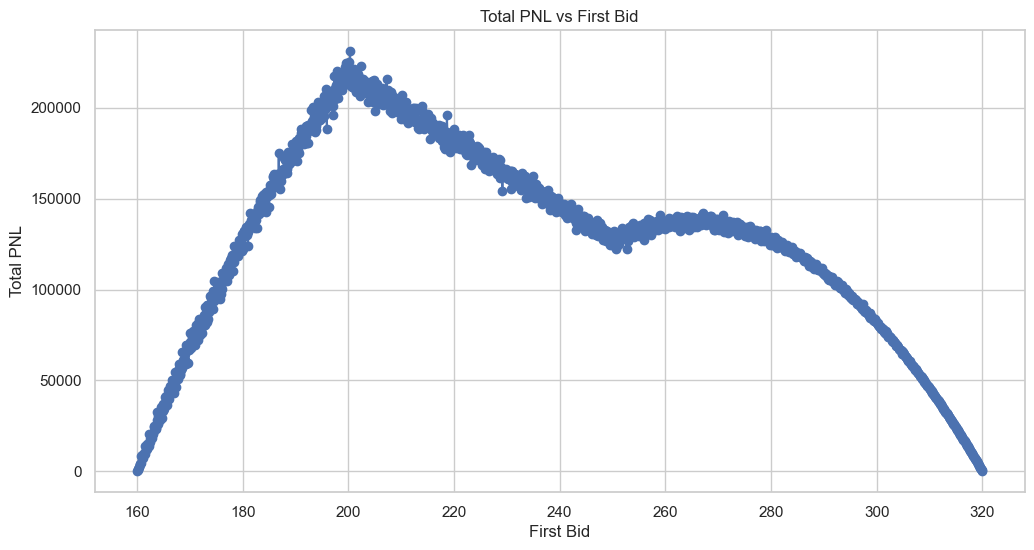

In [227]:
N_SIMULATIONS = 1600

bids = np.linspace(160, 320, N_SIMULATIONS)

# === Monte Carlo Simulation ===
results = []

for sim in tqdm(range(N_SIMULATIONS), desc="Simulating"):
    reserve_prices = sample_reserve_prices(N_TURTLES)
    # reserve_prices = sample_continuous(N_TURTLES)
    first_bid = bids[sim]
    
    pnl = 0
    for reserve in reserve_prices:
        if first_bid >= reserve: # First bid wins
            pnl += 320 - first_bid

    results.append({
        "sim": sim,
        "first_bid": first_bid,
        "Total PNL": pnl
    })

# Graph the results
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.title("Total PNL vs First Bid")
plt.xlabel("First Bid")
plt.ylabel("Total PNL")
plt.plot(bids, [result["Total PNL"] for result in results], marker='o', linestyle='-')
plt.grid(True)
plt.show()

# Two bid scenario (no P)

Simulating: 100%|██████████| 160/160 [00:35<00:00,  4.49it/s]


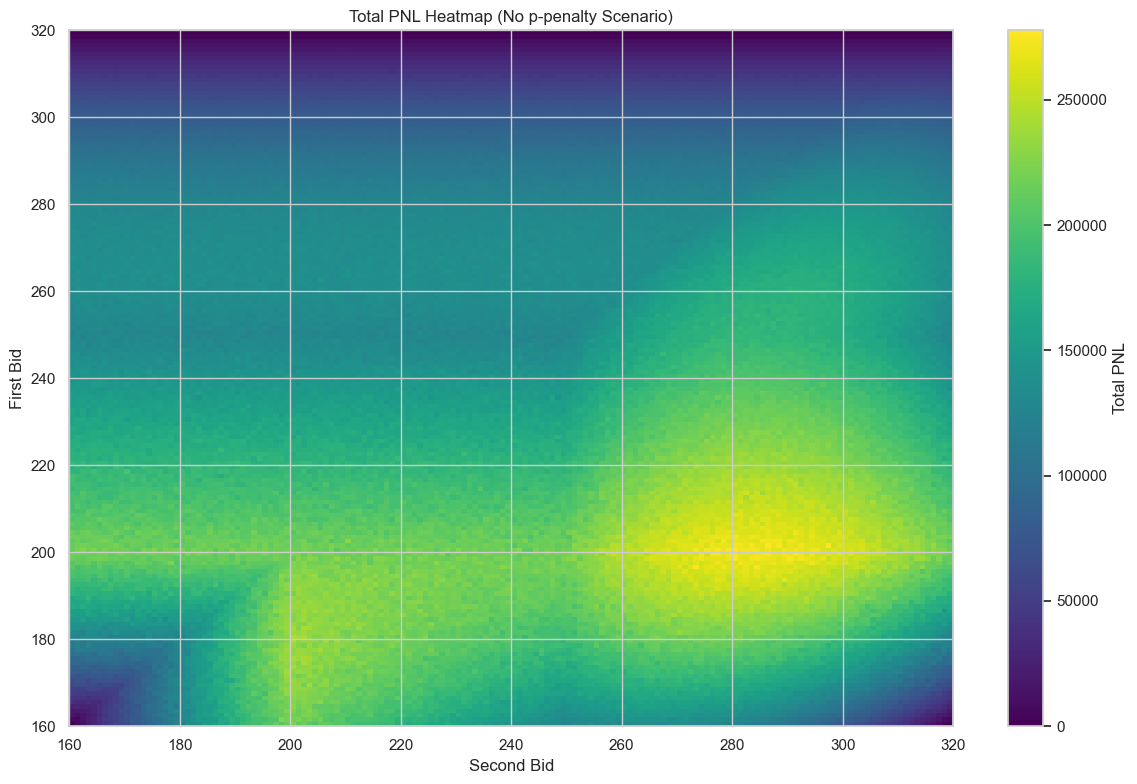

In [228]:
# === Simulation Parameters ===
N_SIMULATIONS = 160 # ^2 in this scenario

first_bids = np.linspace(160, 320, N_SIMULATIONS)
second_bids = np.linspace(160, 320, N_SIMULATIONS)

# === Monte Carlo Simulation ===
results = []
for sim_1 in tqdm(range(N_SIMULATIONS), desc="Simulating"):
    for sim_2 in range(N_SIMULATIONS):
        reserve_prices = sample_reserve_prices(N_TURTLES)
        first_bid = first_bids[sim_1]
        second_bid = second_bids[sim_2]
        
        pnl = 0
        for reserve in reserve_prices:
            if first_bid >= reserve: # First bid wins
                # if (first_bid>200 and first_bid<250): # Turtles dont trade
                #     continue    
                pnl += 320 - first_bid
                
            elif second_bid >= reserve: # Second bid wins
                # if (second_bid>200 and second_bid<250): # Turtles dont trade
                #     continue   
                pnl += (320 - second_bid)

        results.append({
            "first_bid": first_bid,
            "second_bid": second_bid,
            "Total PNL": pnl
        })

import matplotlib.pyplot as plt

# Convert results to DataFrame
df_results_2 = pd.DataFrame(results)

# Pivot to create a grid of PNL values
pivot_df = df_results_2.pivot(index="first_bid", columns="second_bid", values="Total PNL")

# Plotting heatmap
plt.figure(figsize=(12, 8))
plt.title("Total PNL Heatmap (No p-penalty Scenario)")
plt.xlabel("Second Bid")
plt.ylabel("First Bid")
heatmap = plt.imshow(pivot_df.values, origin="lower", aspect="auto",
                     extent=[pivot_df.columns.min(), pivot_df.columns.max(),
                             pivot_df.index.min(), pivot_df.index.max()],
                     cmap="viridis")
plt.colorbar(heatmap, label="Total PNL")
plt.tight_layout()
plt.show()


### Slice @ bid1=200

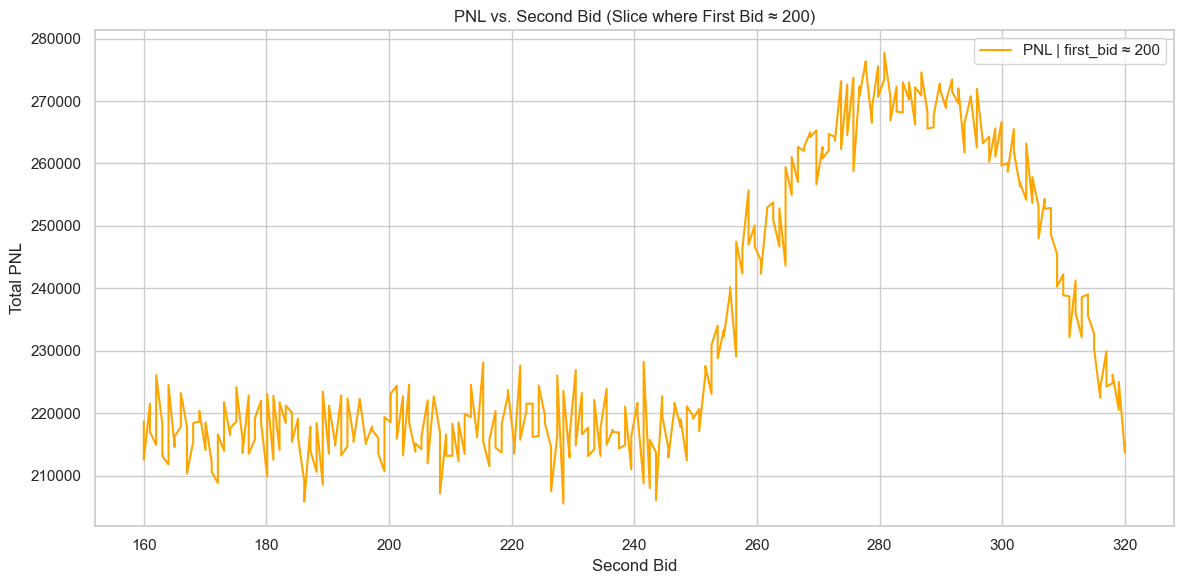

In [229]:
# Extract a slice where first_bid is approximately 200
slice_df = df_results_2[np.isclose(df_results_2["first_bid"], 200, atol=1)]

# Sort by second_bid for proper line plotting
slice_df = slice_df.sort_values("second_bid")

# Plot PNL vs. second_bid for first_bid = 200
plt.figure(figsize=(12, 6))
plt.plot(slice_df["second_bid"], slice_df["Total PNL"], label="PNL | first_bid ≈ 200", color='orange')
plt.xlabel("Second Bid")
plt.ylabel("Total PNL")
plt.title("PNL vs. Second Bid (Slice where First Bid ≈ 200)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 2 Bid scenario (w/ p)

In [230]:
# === Simulation Parameters ===
N_SIMULATIONS = 80 # ^3 in this scenario

first_bids = np.linspace(160, 320, N_SIMULATIONS)
second_bids = np.linspace(160, 320, N_SIMULATIONS)
avg_second_bids = np.linspace(160, 320, N_SIMULATIONS)

# === Monte Carlo Simulation ===
results = []
for sim_1 in tqdm(range(N_SIMULATIONS), desc="Simulating"):
    for sim_2 in range(N_SIMULATIONS):
        for sim_3 in range(N_SIMULATIONS):
            reserve_prices = sample_reserve_prices(N_TURTLES)
            first_bid = first_bids[sim_1]
            second_bid = second_bids[sim_2]
            avg_second_bid = avg_second_bids[sim_3]
            
            pnl = 0
            for reserve in reserve_prices:
                if first_bid >= reserve: # First bid wins
                    # if (first_bid>200 and first_bid<250): # Turtles dont trade
                    #     continue    
                    pnl += 320 - first_bid
                    
                elif second_bid >= reserve: # Second bid wins
                    # if (second_bid>200 and second_bid<250): # Turtles dont trade
                    #     continue
                    if second_bid >= avg_second_bid:
                        pnl += 320 - second_bid
                    else:
                        p = ((320 - avg_second_bid) / (320 - second_bid)) ** 3
                        pnl += (320 - second_bid) * p

            results.append({
                "first_bid": first_bid,
                "second_bid": second_bid,
                "avg_second_bid": avg_second_bid,
                "Total PNL": pnl
            })

# Convert results to DataFrame
df_results_2p = pd.DataFrame(results)

Simulating: 100%|██████████| 80/80 [12:24<00:00,  9.31s/it]


### Slice where bid2=avgbid2 (nash)

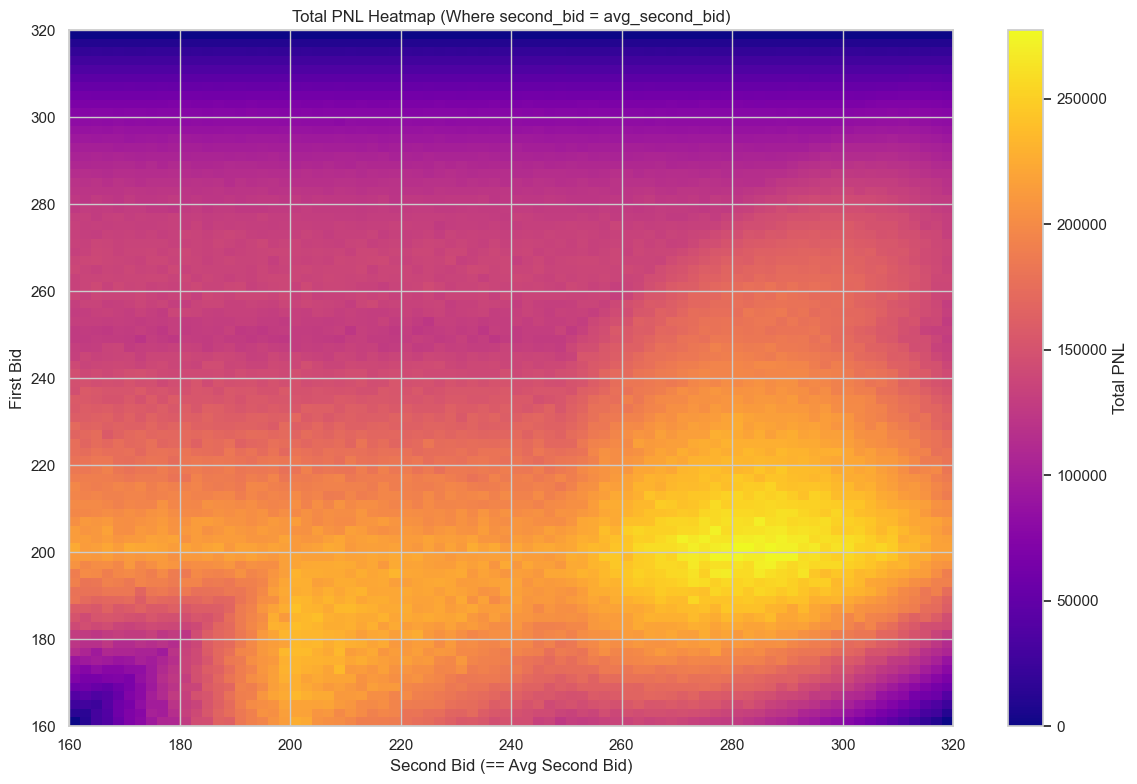

In [231]:
# Filter only where second_bid == avg_second_bid
df_filtered = df_results_2p[np.isclose(df_results_2p["second_bid"], df_results_2p["avg_second_bid"], atol=1e-2)]

# Pivot for heatmap
pivot_df = df_filtered.pivot(index="first_bid", columns="second_bid", values="Total PNL")

# Plot heatmap
plt.figure(figsize=(12, 8))
plt.title("Total PNL Heatmap (Where second_bid = avg_second_bid)")
plt.xlabel("Second Bid (== Avg Second Bid)")
plt.ylabel("First Bid")

heatmap = plt.imshow(
    pivot_df.values,
    cmap="plasma",
    aspect="auto",
    origin="lower",
    extent=[
        pivot_df.columns.min(), pivot_df.columns.max(),
        pivot_df.index.min(), pivot_df.index.max()
    ]
)

plt.colorbar(heatmap, label="Total PNL")
plt.tight_layout()
plt.show()

### Slice where bid2=avgbid2 & firstbid=200

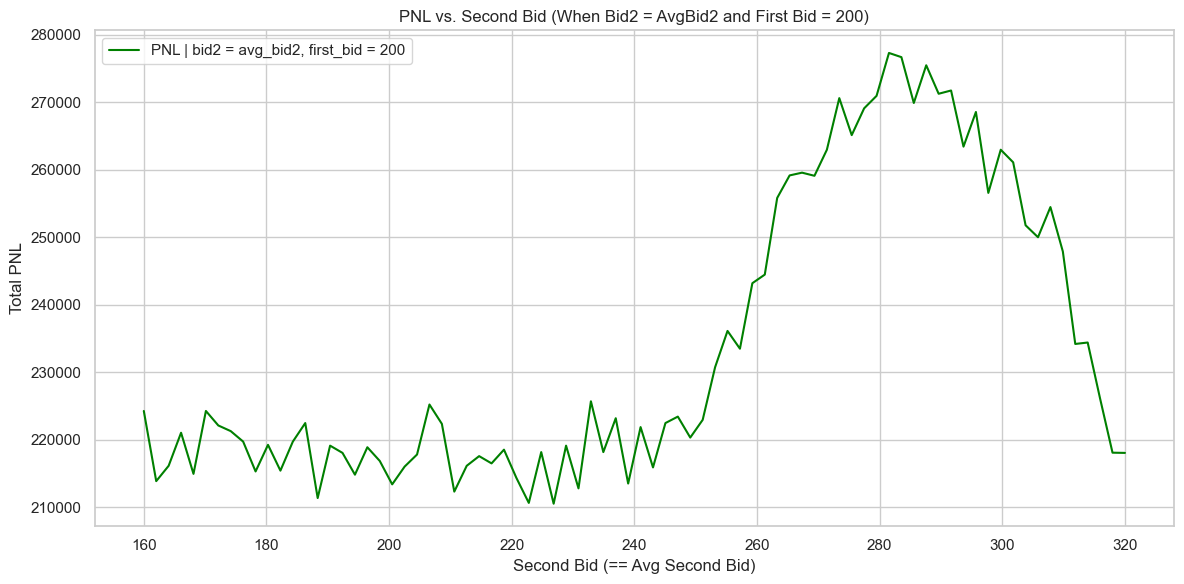

In [232]:
# Filter results: where bid2 == avg_bid2 AND first_bid ≈ 200
filtered_df = df_results_2p[
    np.isclose(df_results_2p["second_bid"], df_results_2p["avg_second_bid"], atol=1) &
    np.isclose(df_results_2p["first_bid"], 200, atol=1)
]

# Sort by second_bid for clean plotting
filtered_df = filtered_df.sort_values("second_bid")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(filtered_df["second_bid"], filtered_df["Total PNL"], label="PNL | bid2 = avg_bid2, first_bid = 200", color='green')
plt.xlabel("Second Bid (== Avg Second Bid)")
plt.ylabel("Total PNL")
plt.title("PNL vs. Second Bid (When Bid2 = AvgBid2 and First Bid = 200)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Run more precise sim

Simulating: 100%|██████████| 10000/10000 [00:59<00:00, 167.37it/s]
C:\Users\nirav\AppData\Local\Temp\ipykernel_50188\1640043039.py:41: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 3 Axes> than <Figure size 1200x800 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(heatmap, label="Total PNL")


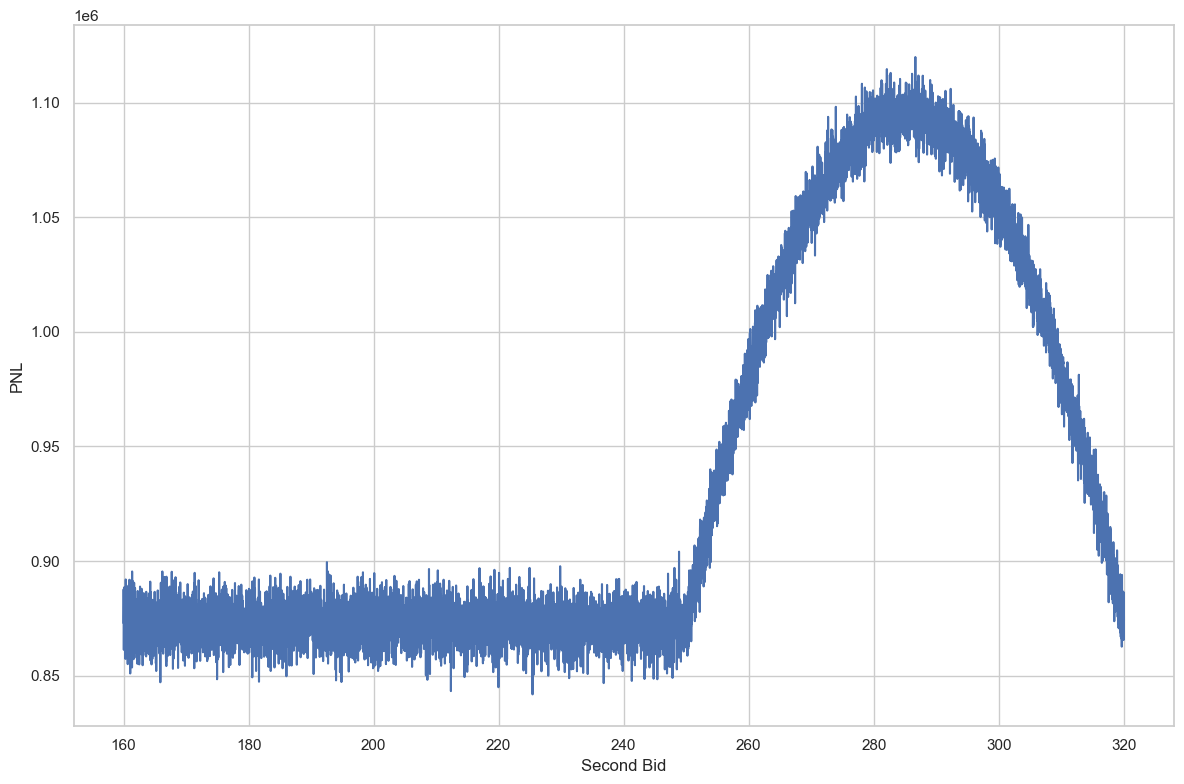

In [233]:
# === Simulation Parameters ===
N_TURTLES = 20000
N_SIMULATIONS = 10000 # ^2 in this scenario

second_bids = np.linspace(160, 320, N_SIMULATIONS)

# === Monte Carlo Simulation ===
results = []
for sim_1 in tqdm(range(N_SIMULATIONS), desc="Simulating"):
        reserve_prices = sample_reserve_prices(N_TURTLES)
        first_bid = 200
        second_bid = second_bids[sim_1]
        
        pnl = 0
        for reserve in reserve_prices:
            if first_bid >= reserve: # First bid wins
                # if (first_bid>200 and first_bid<250): # Turtles dont trade
                #     continue    
                pnl += 320 - first_bid
                
            elif second_bid >= reserve: # Second bid wins
                # if (second_bid>200 and second_bid<250): # Turtles dont trade
                #     continue   
                pnl += (320 - second_bid)

        results.append({
            "second_bid": second_bid,
            "Total PNL": pnl
        })

import matplotlib.pyplot as plt

# Convert results to DataFrame
df_results_2_opt = pd.DataFrame(results)

# Plotting heatmap
plt.figure(figsize=(12, 8))
plt.xlabel("Second Bid")
plt.ylabel("PNL")
plt.plot(df_results_2_opt["second_bid"], df_results_2_opt["Total PNL"])
plt.colorbar(heatmap, label="Total PNL")
plt.tight_layout()
plt.show()


### Make into prob dist

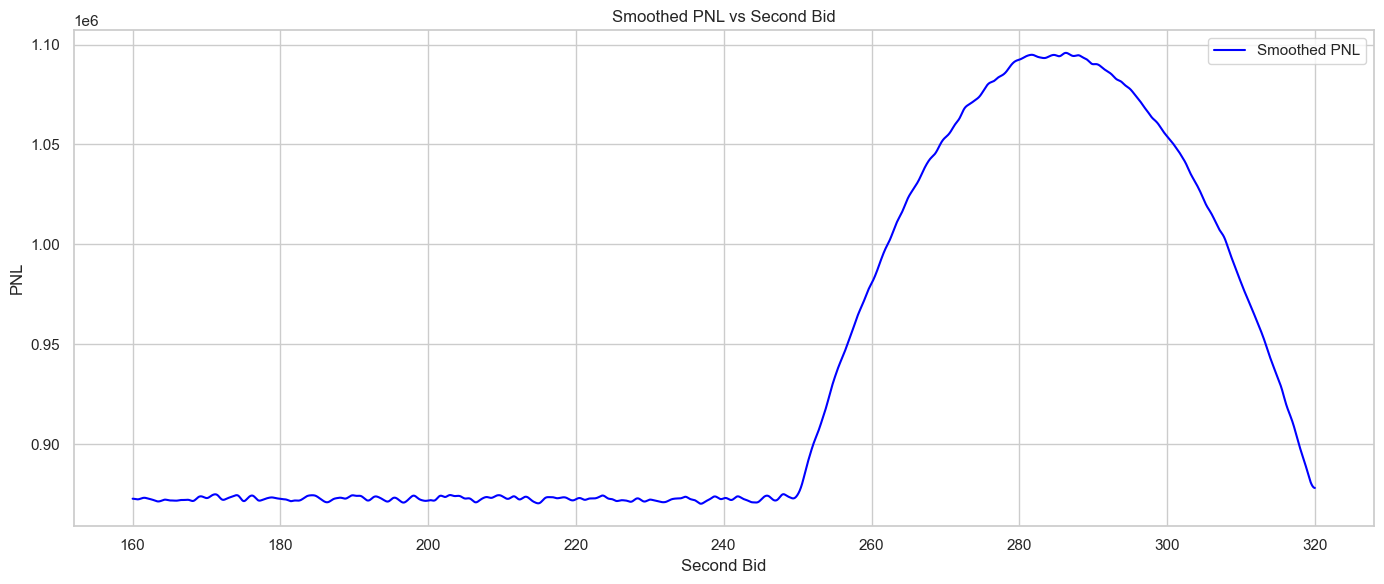

1095833.627698277 286.3006300630063


In [234]:
from scipy.ndimage import gaussian_filter1d
# === Smoothing PNL Curve ===
smoothed_pnl = gaussian_filter1d(df_results_2_opt["Total PNL"], sigma=25)

# === Plot PNL vs Second Bid ===
plt.figure(figsize=(14, 6))
plt.plot(df_results_2_opt["second_bid"], smoothed_pnl, color='blue', label='Smoothed PNL')
plt.title("Smoothed PNL vs Second Bid")
plt.xlabel("Second Bid")
plt.ylabel("PNL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

max_index = np.argmax(smoothed_pnl)
best_second_bid = df_results_2_opt["second_bid"].iloc[max_index]
best_pnl = smoothed_pnl[max_index]

print(best_pnl, best_second_bid)

### Create alternative scenario dist's

C:\Users\nirav\AppData\Local\Temp\ipykernel_50188\1086706600.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


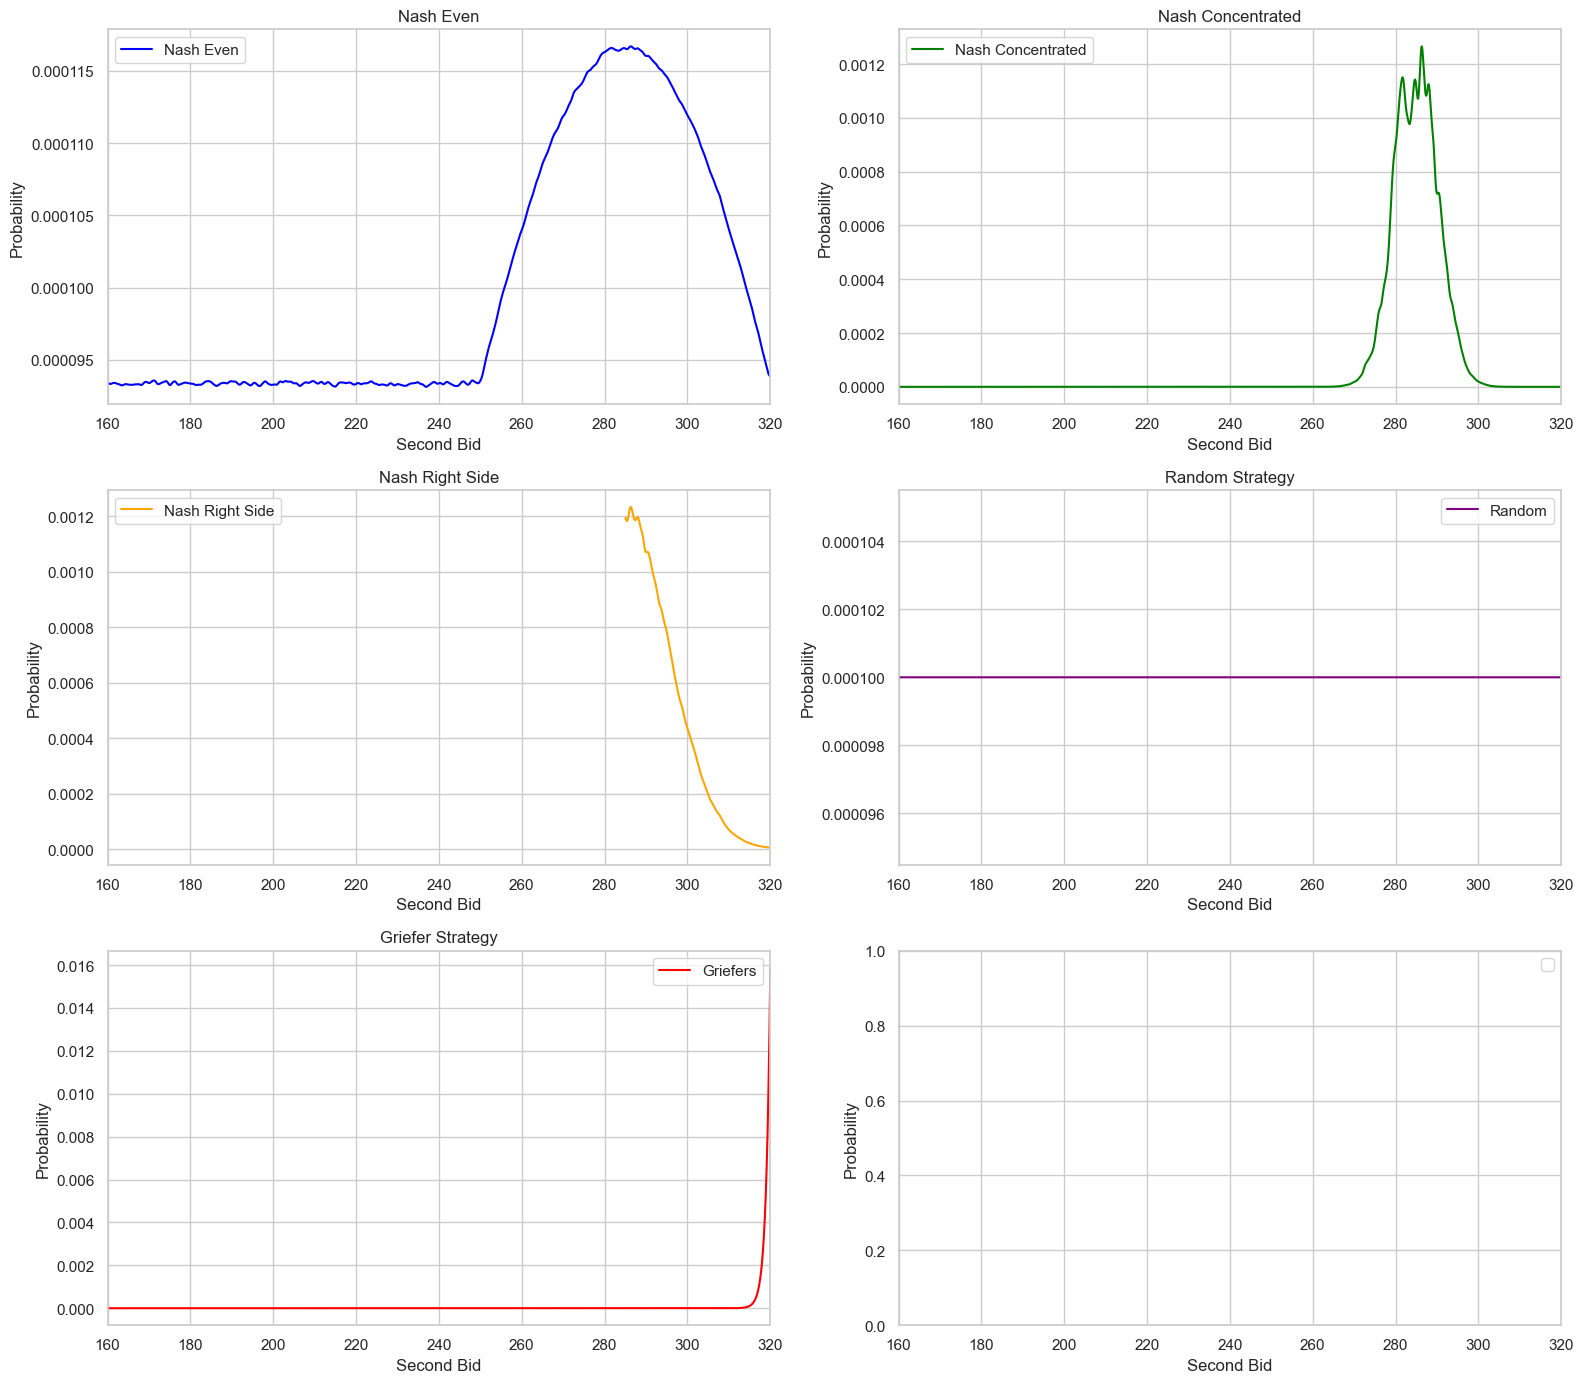

In [235]:
# Create bid range and smooth PNL first (if not already available)
second_bids = df_results_2_opt["second_bid"].values
smoothed_pnl = gaussian_filter1d(df_results_2_opt["Total PNL"], sigma=25)

# === Nash Even ===
temp_even = 1_000_000
shifted_even = smoothed_pnl - np.max(smoothed_pnl)
probs_even = np.exp(shifted_even / temp_even)
probs_even /= probs_even.sum()

# === Nash Concentrated ===
temp_concentrated = 10_000
shifted_concentrated = smoothed_pnl - np.max(smoothed_pnl)
probs_concentrated = np.exp(shifted_concentrated / temp_concentrated)
probs_concentrated /= probs_concentrated.sum()

# === Nash Right Side (filtered above 285) ===
temp_even_right = 40_000
mask_right = second_bids >= 285
filtered_pnl = smoothed_pnl[mask_right]
shifted_right = filtered_pnl - np.max(filtered_pnl)
probs_right = np.exp(shifted_right / temp_even_right)
probs_right /= probs_right.sum()
second_bids_right = second_bids[mask_right]

# === Random (Uniform) ===
probs_random = np.ones_like(second_bids) / len(second_bids)

# === Griefers (tails at 160 and 320) ===
tail_right = np.exp(-(320 - second_bids) / 1)
probs_grief = tail_right
probs_grief /= probs_grief.sum()

# Plotting all 5
fig, axs = plt.subplots(3, 2, figsize=(16, 14))
axs = axs.flatten()

axs[0].plot(second_bids, probs_even, label="Nash Even", color='blue')
axs[0].set_title("Nash Even")
axs[1].plot(second_bids, probs_concentrated, label="Nash Concentrated", color='green')
axs[1].set_title("Nash Concentrated")
axs[2].plot(second_bids_right, probs_right, label="Nash Right Side", color='orange')
axs[2].set_title("Nash Right Side")
axs[3].plot(second_bids, probs_random, label="Random", color='purple')
axs[3].set_title("Random Strategy")
axs[4].plot(second_bids, probs_grief, label="Griefers", color='red')
axs[4].set_title("Griefer Strategy")

for ax in axs:
    ax.set_xlabel("Second Bid")
    ax.set_ylabel("Probability")
    ax.set_xlim(160,320)
    ax.grid(True)
    ax.legend()

fig.tight_layout()
plt.show()


# Monte Carlo sim

Simulating:   0%|          | 0/5000 [00:00<?, ?it/s]

Simulating: 100%|██████████| 5000/5000 [00:30<00:00, 165.25it/s]


AVG SECOND BID:  291.54888844213355


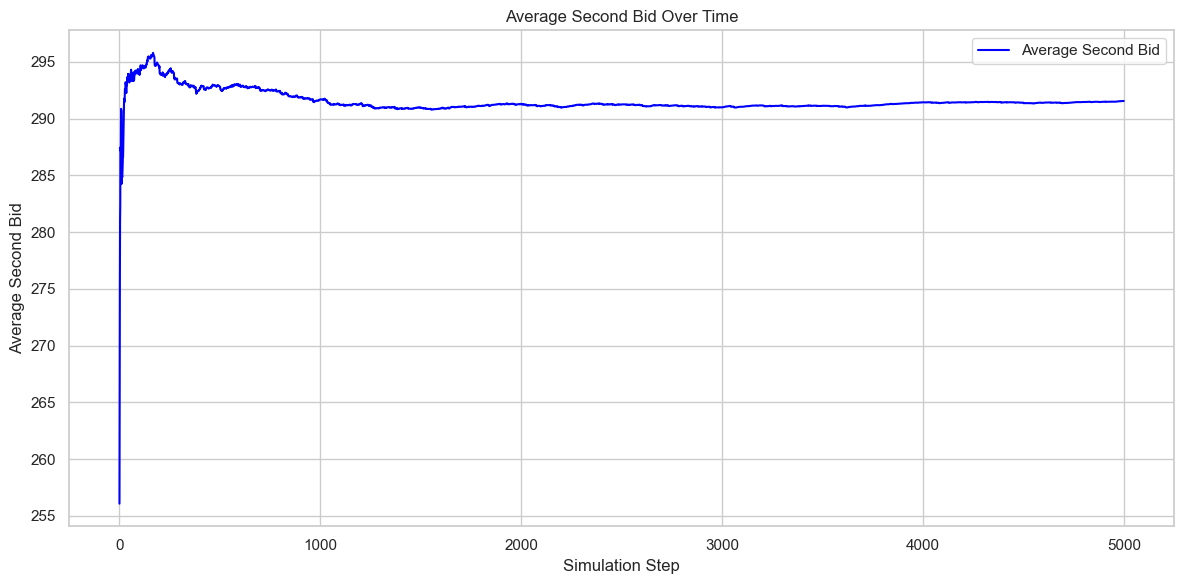

second_bid       293.670886
Total PNL     276642.025316
Name: 133345, dtype: float64

In [237]:
# === Simulation Parameters ===k
N_SIMULATIONS = 5000 # 

avg_first_bids = []
avg_second_bids = [285]

# === Monte Carlo Simulation ===
results = []
reserve_prices = sample_reserve_prices(N_TURTLES)
import random

strategies = [
    ("nash", 0.10),
    ("nash_conc", 0.30),
    ("nash_right", 0.60),
    ("random", 0.01),
    ("grief", 0.20),
]

# Normalize weights
strategy_names = [s[0] for s in strategies]
strategy_weights = np.array([s[1] for s in strategies])
strategy_weights = strategy_weights / strategy_weights.sum()

# Assuming everyone chooses 200 as first bid (if they didn't they arent smart enough to make a good calc on bid2, factor it into randomness)
first_bid = 200
for sim_1 in tqdm(range(N_SIMULATIONS), desc="Simulating"):
    strategy = np.random.choice(strategy_names, p=strategy_weights)

    if strategy == "nash":
        second_bid = np.random.choice(second_bids, p=probs_even)
    elif strategy == "nash_conc":
        second_bid = np.random.choice(second_bids, p=probs_concentrated)
    elif strategy == "nash_right":
        second_bid = np.random.choice(second_bids_right, p=probs_right)
    elif strategy == "random":
        second_bid = np.random.choice(second_bids, p=probs_random)
    elif strategy == "grief":
        second_bid = np.random.choice(second_bids, p=probs_grief)

    avg_second_bids.append(second_bid)
    avg_second_bid = np.mean(avg_second_bids)

    pnl = 0
    for reserve in reserve_prices:
        if first_bid >= reserve: # First bid wins
            # if (first_bid>200 and first_bid<250): # Turtles dont trade
            #     continue    
            pnl += 320 - first_bid
            
        elif second_bid >= reserve: # Second bid wins
            # if (second_bid>200 and second_bid<250): # Turtles dont trade
            #     continue

            if second_bid >= avg_second_bid:
                pnl += 320 - second_bid
            else:
                p = ((320 - avg_second_bid) / (320 - second_bid)) ** 3
                pnl += (320 - second_bid) * p

    results.append({
        "n": sim_1,
        "first_bid": first_bid,
        "second_bid": second_bid,
        "avg_second_bid": avg_second_bid,
        "Total PNL": pnl
    })

print("AVG SECOND BID: ", np.mean(avg_second_bids))

# Convert results to DataFrame
df_results_2p_nash = pd.DataFrame(results)

# Plot average second bid over time
plt.figure(figsize=(12, 6))
plt.plot(df_results_2p_nash["n"], df_results_2p_nash["avg_second_bid"], label="Average Second Bid", color='blue')
plt.title("Average Second Bid Over Time")
plt.xlabel("Simulation Step")
plt.ylabel("Average Second Bid")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

tolerance = 1  # allowable deviation for filtering

# Filter DataFrame for matches on first bid and avg second bid
filtered_df = df_results_2p[
    (np.isclose(df_results_2p["first_bid"], 200, atol=tolerance)) &
    (np.isclose(df_results_2p["avg_second_bid"], np.mean(avg_second_bids), atol=tolerance))
]

# Find the optimal second bid (max PNL)
optimal_row = filtered_df.sort_values("Total PNL", ascending=False).iloc[0][["second_bid", "Total PNL"]]
optimal_row